In [368]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [369]:
def fakelinedata(m, b, xspan, pointnum, roughstd):
    x = .001*np.array(random.sample(range(xspan*1000), pointnum))
    
    noise = np.random.normal(1, roughstd, pointnum)
    y = m*x + b + noise
    
    fakeerror = np.random.normal(1, roughstd, pointnum)
    fakearray = np.array([x,y])
    return fakearray, fakeerror

In [370]:
data, error = fakelinedata(5,-2,30, 40, 15)

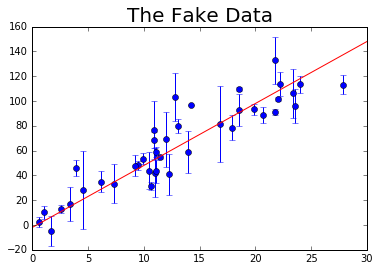

In [371]:
plt.errorbar(data[0,0:], data[1,0:], yerr = error, fmt = 'o')
plt.plot(np.linspace(0,30,100), 5*np.linspace(0,30,100)-2, 'r')
plt.title('The Fake Data', fontsize = 20)

In [372]:
def logL(theta, x, y, sigma):
    model = theta[0] * x + theta[1]
    return -0.5*(np.sum((y-model)**2/sigma**(2.) + np.log(2*np.pi*sigma**2)))

def lnprior(theta):
    if theta[0] > 0 and theta[1] < 10.:
        return 1.
    else:
        return -np.inf

def lnprob(theta, x, y, sigma):
    return lnprior(theta) + logL(theta, x, y, sigma)


def Gaussian_MCMC(nsteps, x, y, error):
    import numpy as np
    n = 0
    m = [.3]
    b = [.1]
    probs = []
    acceptance = 0
    stepsize = 10.
    probs.append(lnprob((m[0],b[0]), x, y, error))
    for n in range(nsteps):
        m_guess = random.gauss(m[n], stepsize)
        b_guess = random.gauss(b[n], stepsize)
        prob_calc = lnprob((m_guess, b_guess), x, y, error)
        if prob_calc > probs[n]:
            probs.append(prob_calc)
            m.append(m_guess)
            b.append(b_guess)
            acceptance += 1
        else:
            if prob_calc > random.uniform(.25, .5):
                probs.append(prob_calc)
                m.append(m_guess)
                b.append(b_guess)
                acceptance += 1
            else:
                probs.append(probs[n])
                m.append(m[n])
                b.append(b[n])

        n+= 1
    probs[::-1].pop()
    probs[::-1].pop()
    thetas = (m, b)
    thetas = np.asarray(thetas)
    thetas = np.transpose(thetas)
    print('acceptance ratio = %s' %(acceptance/nsteps))
    return probs, thetas

In [373]:
probs, thetas = Gaussian_MCMC(1000000, data[0,0:], data[1,0:], error)

acceptance ratio = 1e-05


This is a hideously low acceptance fraction, and I couldn't get through to the program to make it more generous. This wasn't a problem when we were just resampling a Gaussian!

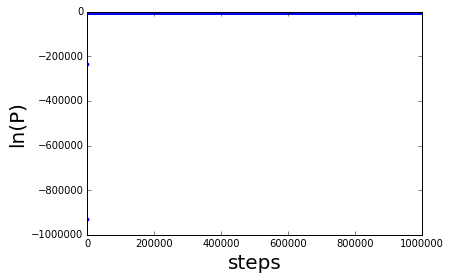

In [374]:
plt.plot(probs, '.')
plt.xlabel('steps', fontsize = 20)
plt.ylabel('ln(P)', fontsize = 20)

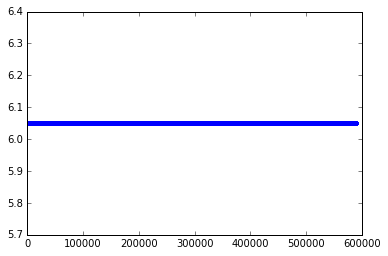

In [375]:
plt.plot(thetas[410000:,0], '.')

(array([      0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  590001.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.]),
 array([ 5.55114514,  5.58447847,  5.6178118 ,  5.65114514,  5.68447847,
         5.7178118 ,  5.75114514,  5.78447847,  5.8178118 ,  5.85114514,
         5.88447847,  5.9178118 ,  5.95114514,  5.98447847,  6.0178118 ,
         6.05114514,  6.08447847,  6.1178118 ,  6.15114514,  6.18447847,
         6.2178118 ,  6.25114514,  6.28447847,  6.3178118 ,  6.35114514,
         6.38447847,  6.4178118 ,  6.45114514,  6.48447847,  6.5178118 ,
         6.55114514]),
 <a list of 30 Patch objects>)

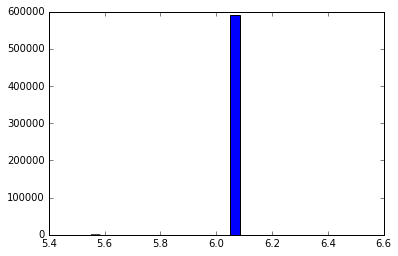

In [376]:
plt.hist(thetas[410000:,0], bins = 30)

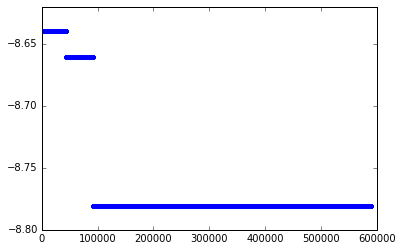

In [357]:
plt.plot(thetas[410000:,1], '.')

(array([ 499022.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,   48454.,       0.,       0.,       0.,   42525.]),
 array([-8.78060942, -8.77592211, -8.77123481, -8.76654751, -8.76186021,
        -8.7571729 , -8.7524856 , -8.7477983 , -8.743111  , -8.73842369,
        -8.73373639, -8.72904909, -8.72436179, -8.71967448, -8.71498718,
        -8.71029988, -8.70561258, -8.70092527, -8.69623797, -8.69155067,
        -8.68686337, -8.68217606, -8.67748876, -8.67280146, -8.66811416,
        -8.66342685, -8.65873955, -8.65405225, -8.64936495, -8.64467764,
        -8.63999034]),
 <a list of 30 Patch objects>)

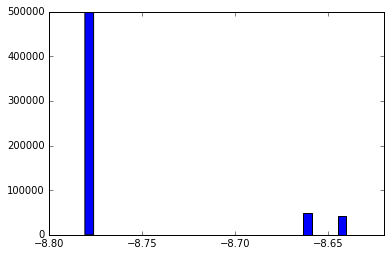

In [358]:
plt.hist(thetas[410000:,1], bins = 30)

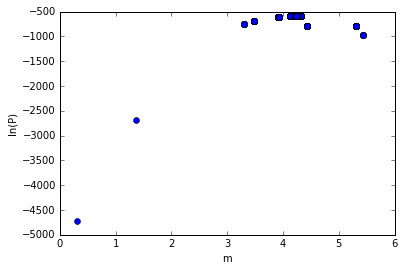

In [367]:
plt.plot(thetas[0:,0], probs, 'o')
plt.xlabel('m')
plt.ylabel('ln(P)')

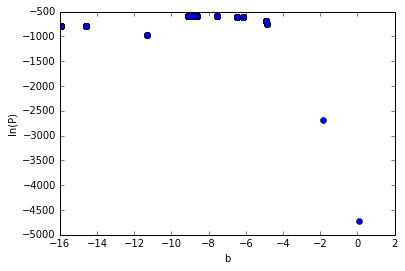

In [366]:
plt.plot(thetas[0:,1], probs, 'o')
plt.xlabel('b')
plt.ylabel('ln(P)')

If my MC were running better, there would be a Gaussian distribution in these lnP vs m and lnP vs b diagrams. For some reason, though, the method had an incredibly low acceptance rate as visible above and had a tendency to "stick" to values until they were forced by the Monte Carlo to a transcendently better value.

In [284]:
import emcee
import corner

In [361]:
# creating the emcee chains

ndim, nwalkers = 3, 100
pos = [1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (data[0,0:], data[1,0:], error))
sampler.run_mcmc(pos, 5000)


/home/max/anaconda2/envs/moresnakes/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/max/anaconda2/envs/moresnakes/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[  4.19902798e+000,  -8.60084275e+000,   1.84230095e+243],
        [  4.22379885e+000,  -8.66401366e+000,  -2.03433191e+242],
        [  4.20540849e+000,  -8.21076049e+000,   4.93992387e+242],
        [  4.14260881e+000,  -8.53231278e+000,   4.02634941e+241],
        [  4.28484892e+000,  -9.07802091e+000,  -5.63386874e+242],
        [  4.30816320e+000,  -9.29861269e+000,   7.58540010e+241],
        [  4.32541168e+000,  -9.33806578e+000,  -1.49553659e+240],
        [  4.42803600e+000,  -9.99787315e+000,  -2.26078375e+243],
        [  4.24150620e+000,  -8.80290355e+000,  -2.87189822e+242],
        [  4.18529082e+000,  -8.19449010e+000,   3.83108351e+241],
        [  4.19829817e+000,  -8.54981981e+000,   8.13509758e+242],
        [  4.16123035e+000,  -8.34913063e+000,  -1.20334829e+242],
        [  4.30752512e+000,  -9.54610706e+000,   1.22371824e+243],
        [  4.26705183e+000,  -9.01240456e+000,  -9.50337195e+241],
        [  4.20826106e+000,  -8.73006013e+000,  -9.80315487e+2

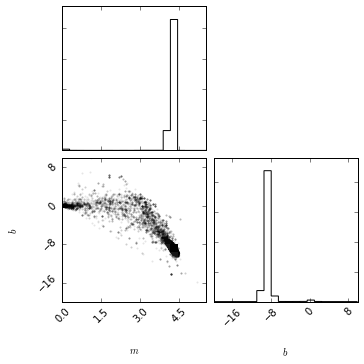

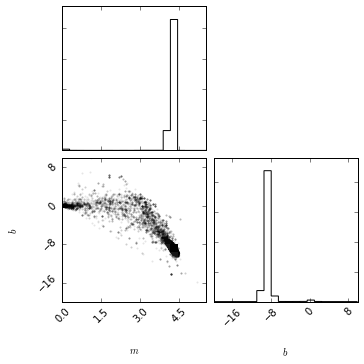

In [363]:
corner.corner(sampler.flatchain[0:,:2], labels=['$m$', '$b$'], fontsize = 20)

# I don't know why it likes to print out two of these but ok!

These are incredibly peaky distributions for m and b. It seems foolhardy to even add standard deviations.

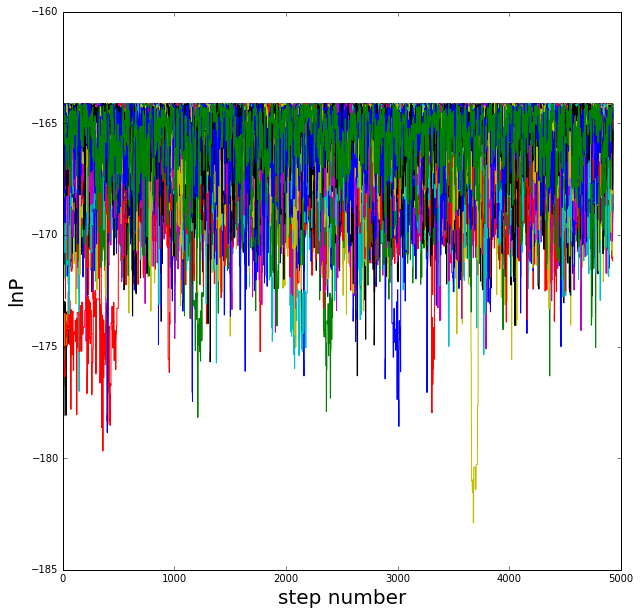

In [333]:
plt.figure(figsize = (10,10))
[plt.plot(sampler.lnprobability[i,70:]) for i in range(100)]
plt.xlabel('step number', fontsize = 20)
plt.ylabel('lnP', fontsize = 20)

# I have already cut out the burn-in for the chains

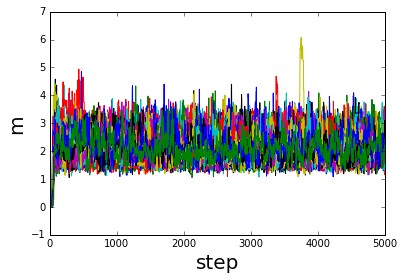

In [335]:
[plt.plot(sampler.chain[i,:,0]) for i in range(100)]
plt.xlabel('step', fontsize = 20)
plt.ylabel('m', fontsize = 20)

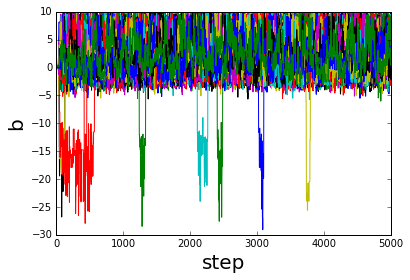

In [336]:
[plt.plot(sampler.chain[i,:,1]) for i in range(100)]
plt.xlabel('step', fontsize = 20)
plt.ylabel('b', fontsize = 20)